# MagPy example workflow

In [1]:
from IPython.display import Image
import sys
sys.path.append('..')

Import all of the MagPy modules

In [2]:
%matplotlib inline

In [3]:
import magpy.changepoint as changepoint
import magpy.denoise as denoise
import magpy.inputoutput as inputoutput
import magpy.svplots as svplots
import magpy.svtools as svtools

These are a few the locations of the land-based geomagnetic observatories we can consider. We will choose a handful of observatories to look at in this analysis.

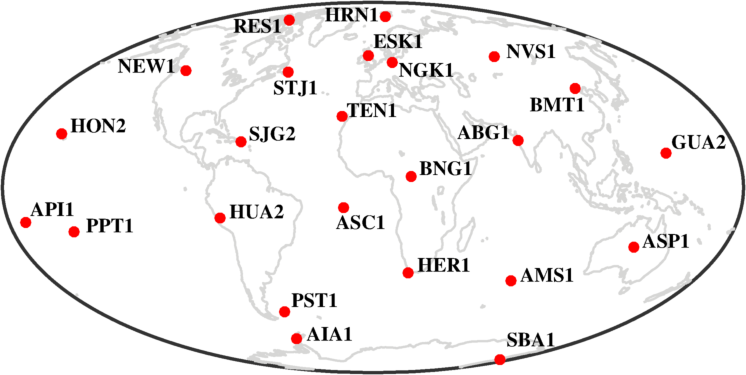

In [4]:
Image(filename="/Users/Grace/Dropbox/PhD/writing/clm_source/figs/map_obs.png")

# Input/output

In [ ]:
obs_names = ['aqu', 'had', 'ngk']

The World Data Centre data are stored in fortran formatted fixed-width .wdc files, which need to be parsed and placed into an easier to use data format. The contents of the files look like this:

Column 1-3: Observatory 3-letter code

Column 4-5: Last two digits of the year (e.g. 1996 = 96. See also columns 15-16).

Column 6-7: Month (01-12)

Column 8: Element (D,I,H,X,Y,Z, or F)

Column 9-10: Day of the month (01-31)

Column 11-12: Blanks

Column 13: Arbitrary

Column 14: Arbitrary

Column 15-16: Century digits (e.g. year = 1889, century digits = 18, year = 1996, century digits = 19, year = 2014, century digits = 20)
                   
Column 17-20: Tabular base. The values are in degrees for D and I, and in hundreds of nanotesla for the intensity elements.
                   
Column 21-116: 24 4-digit hourly mean values for the day. The values are in tenth-minutes for D and I, and in nanoteslas for the intensity elements. The first hourly mean value represents the mean value between 00:00 UT and 01:00 UT, ..., the 24th value represents the mean between 23:00 UT and 24:00 UT. A missing value is identified by 9999.
                   
Column 117-120: Daily mean. If any of the hourly mean values for the day are missing 999 will appear as the daily mean.
                   
Column 121-122: Record end marker. Two characters 'cr'= 13 and 'nl'= 10.

The tabular bases, hourly mean values and daily means are right adjusted and signed if negative. Negative values are identified with a minus sign either adjacent to the first significant digit or in the high-order position  of the field. NOTE: A blank digit will not appear between a (-) sign and the first significant digit. For example, a value may appear as -050 or b-50 but not as -b50 (b=blank).

The 25 values in positions 21-120 will have the range -999 to 9998, with 9999 reserved for missing values. 

The records are sorted according to observatory code, year, month, element, day (positions 1-10).

For the intensity elements we have that
     hourly value (nanoTeslas) = tab.base*100 + tab.value

For the angles D and I we have that
     hourly value (Degrees) = tab.base + tab.value/600



In [6]:
inputoutput.wdc_to_daily_csv('../magpy/data/BGS_hourly/hourval/single_obs/*')

aaa


FileNotFoundError: [Errno 2] No such file or directory: './data/wdc_daily/aaa.csv'

Extract all data from the WDC files, convert into the proper daily means using the tabular base and save the X, Y and Z components to CSV files.

In [ ]:
for observatory in obs_names:
    print(observatory)
    wdc_data = inputoutput.append_wdc_data(observatory)
    resampled_field_data = svtools.data_resampling(wdc_data)
    sv_data = svtools.calculate_sv(resampled_field_data)
    inputoutput.write_csv_data(sv_data, "./data/", observatory)

We need some secular variation predictions from a geomagnetic field model. I will use the COV-OBS model in this example because MagPy knows how to parse the output files of this field model (more to follow). Let's concatenenate the data for our selected observatories.

In [ ]:
obs_data, model_data = inputoutput.combine_csv_data(obs_list=obs_names,
                data_path="/Users/Grace/MagPy/example/data/",
                model_path="/Users/Grace/Dropbox/cov-obs_x1/monthly_vals/")

In [ ]:
model_data = model_data[model_data['date'].isin(obs_data['date'])]

# Plotting

In [ ]:
for observatory in obs_names:
    svplots.plot_sv(dates=obs_data.date, sv=obs_data.filter(regex=observatory), model=model_data.filter(regex=observatory),
                    fig_size=(15, 10), font_size=20, label_size=24, plot_legend=True, obs=observatory)

# External noise removal

Compute the residuals

In [ ]:
residuals = svtools.calculate_residuals(obs_data=obs_data, model_data=model_data)

In [ ]:
dates = model_data['date'].values

In [ ]:
model_data.drop(['date'], axis=1, inplace=True)

In [ ]:
denoised, proxy, eigenvals = denoise.eigenvalue_analysis(dates=dates, obs_data=obs_data, model_data=model_data, residuals=residuals)

Plot the denoised SV

In [ ]:
for observatory in obs_names:
    svplots.plot_sv(dates=dates, sv=denoised.filter(regex=observatory), model=model_data.filter(regex=observatory),
                    fig_size=(15, 10), font_size=20, label_size=24, plot_legend=True, obs=observatory)

Plot the eigenvalues of the covariance matrix of the residuals

In [ ]:
svplots.plot_eigenvalues(eigenvals)

Compare the proxy signal used to denoise the data with the Dcx index (extended, corrected Dst index). Both signals are reduced to zero-mean and unit variance (z-score).

In [ ]:
svplots.plot_dcx(date=denoised.date, signal=proxy, fig_size=(15, 10), font_size=20, label_size=24, plot_legend=True)

Look at the DFT of the proxy signal and Dcx index

# Changepoint analysis

In [ ]:
cp = changepoint.change_point_analysis(signal=denoised.Yaqu, cpm_method="Kolmogorov-Smirnov")

In [ ]:
changepoint.plot_cpa_results(dates=denoised.date, signal=denoised.Yaqu, results=cp)

There's still some spikes in the data. Repeat the analysis only using daily means from days with an Ap value below a certain threshold.

In [ ]:
for observatory in obs_names:
    print(observatory)
    wdc_data = inputoutput.append_wdc_data(observatory)
    daily_field_data = svtools.apply_Ap_threshold(Ap_path='../magpy/data/Ap_daily.txt', obs_data=wdc_data, threshold=None)
    resampled_field_data = svtools.data_resampling(daily_field_data)
    sv_data = svtools.calculate_sv(resampled_field_data)
    inputoutput.write_csv_data(sv_data, "./data/", observatory)